# 1. Loading main packages and functions 

In [1]:
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import itertools
import argparse
import sys
import time
import pickle 
import matplotlib2tikz
from datasets import get_data

# Prepare dataset
target_dataset_list = ['communities', 'power', 'MNIST']
target_dataset = target_dataset_list[2]
X_train, X_test, y_train, y_test, no_class = get_data(target_dataset)

# make a copy for one-vs-all multiclass classification
y_train_original = np.copy(y_train)  
y_test_original = np.copy(y_test)

#hyper_parameters = {'lambda': 0.1}

from FunctionsLibrary import *

Using TensorFlow backend.


# 2. Main loops, no quantization, binary classification 


In [2]:
if no_class==2:
    # Initialize weights
    w_0 = initialize_w(X_train.shape[1])
    
    hyper_parameters = {'learning_rate': 0.2, 'lambda': 0.1, 'iterations': 50, 
                        'SVRG_epoch_size': 15}
    outputs = optimizer_no_quantization_binary_classification(target_dataset, X_train, y_train, X_test, y_test,
                                                              w_0, hyper_parameters)
    pickle_file_name = './TestResults/outputs_noQuant_'+target_dataset
    with open(pickle_file_name+'.pickle', 'wb') as f:
        pickle.dump(outputs, f)
        
else:
    print('Go to Section 3(b) for one-vs-all multiclass classification')

Go to Section 3(b) for one-vs-all multiclass classification


# 3(a). Quantization with fixed and adaptive grids, binary classification 

We have added some functions into `FinctionsLibrrary.py` to handle quantization with fixed grids. For them, we need to add four more attributes to the `hyper_parameters`: number of bits `no_bits` and quantization radius for every coordinate `Range` for both parameter quantization and gradient quantizations. 

To design our adaptive grid quantizer, we need to characterize our optimization landscape. Our optimization problem is  
$$
\min_{\mathbf{w}} F(\mathbf{w}) =  \frac{1}{N}\sum_{i \in [N]} \ln \left( 1 + e^{-y_i \mathbf{w}^T \mathbf{x}_i}\right)  + \lambda \|\mathbf{w}\|_2^2 \:,
$$
where each summand is $f_i(\mathbf{w})$. 
Define $\mathbf{z}_i := y_i \mathbf{x}_i$. Now, we characterize the geometry of our problem:
- `Smoothness parameter` $L = \sum_{i \in [N]} \|\mathbf{z_i} \|_2^2/4N + 2 \lambda$: 
$$\lambda_{\max} \left( \nabla^2 F(\mathbf{w}\right) \leq \frac{1}{N} \sum_{i \in [N]} \lambda_{\max} \left( \nabla^2 f_i(\mathbf{w})\right) + 2 \lambda \leq \frac{1}{4N} \sum_{i \in [N]} \|\mathbf{z_i} \|_2^2 + 2 \lambda \:.
$$
- `Strong convexity parameter` $\mu = 2 \lambda$: 
$$\lambda_{\min} \left( \nabla^2 F(\mathbf{w}\right) \geq \frac{1}{N} \sum_{i \in [N]} \lambda_{\min} \left( \nabla^2 f_i(\mathbf{w})\right) + 2 \lambda \geq 2 \lambda \:.
$$
Given `smoothness_param` = $L$ and `strong_convexity_param ` = $\mu$, we first develop of quantized SVRG optimizer with adaptive grid in a method called `SVRG_adaptive_quantization`. 

Moreover, we use the following inequalities
$$
\|\tilde{\mathbf{w}}_{k+1} - \tilde{\mathbf{w}}_{k} \| \leq \|\tilde{\mathbf{w}}_{k+1} - {\mathbf{w}}^{\star} \| + \|\tilde{\mathbf{w}}_{k} - \tilde{\mathbf{w}}_{k} \| 
\leq \frac{\left(\|\nabla F(\tilde{\mathbf{w}}_{k+1}) \| + \|\nabla F(\tilde{\mathbf{w}}_{k}) \| \right)}{\mu} 
\leq \frac{2 \|\nabla F(\tilde{\mathbf{w}}_{k}) \|}{\mu}  
\:,
$$
and
$$
\|\nabla F(\tilde{\mathbf{w}}_{k+1}) - \nabla F(\tilde{\mathbf{w}}_{k}) \| 
\leq \|\nabla F(\tilde{\mathbf{w}}_{k+1})\| + \| \nabla F(\tilde{\mathbf{w}}_{k}) \|
\leq 2 \| \nabla F(\tilde{\mathbf{w}}_{k}) \|
\:.
$$
These inequalities ensure that $\nabla F(\tilde{\mathbf{w}}_{k+1})$ (no matter its true value or quantized version), should be within $2 \| \nabla F(\tilde{\mathbf{w}}_{k}) \| / \mu $ distance of $\nabla F(\tilde{\mathbf{w}}_{k})$. Therefore, we construct an adaptive grid size to quantize *parameter vector at the server* by setting `grid_center` = $\tilde{\mathbf{w}}_{k}$ and `quantization_radius` =  $2 \| \nabla F(\tilde{\mathbf{w}}_{k}) \| / \mu$. Similarly, we can construct an adaptive grid size to quantize *gradient vector at the workers* by setting `grid_center` = $\nabla F(\tilde{\mathbf{w}}_{k})$ and `quantization_radius` =  $2 \| \nabla F(\tilde{\mathbf{w}}_{k}) \|$. 




In [7]:
if no_class==2:
    # Initialize weights
    w_0 = initialize_w(X_train.shape[1])
    grad_quantization_opt = {'no_bits': 22, 'Range': 40}
    parameter_quantization_opt = {'no_bits': 22, 'Range': 40}
    hyper_parameters = {'lambda': 0.1, 'iterations': 10, 'SVRG_epoch_size': 8,
                        'parameter_quantization_opt': parameter_quantization_opt,
                        'grad_quantization_opt': grad_quantization_opt}
    
    hyper_parameters['strong_convexity_param'] = 2 * hyper_parameters['lambda']
    Z = [X_train[i]*y_train[i] for i in range(X_train.shape[0])]
    hyper_parameters['smoothness_param'] = np.linalg.norm(Z)**2 / (4 * X_train.shape[0]) + 2 * hyper_parameters['lambda']
    #hyper_parameters['learning_rate'] = 1/(4*hyper_parameters['smoothness_param'])
    hyper_parameters['learning_rate'] = 0.2

    outputs = optimizer_quantization_binary_classification(target_dataset, X_train, y_train, X_test, y_test,
                                                           w_0, hyper_parameters, 
                                                           multi_class=False, plot=False, printout=True)
    pickle_file_name = './TestResults/outputs_P_'+str(hyper_parameters['parameter_quantization_opt']['no_bits'])+'_Q_'+str(hyper_parameters['grad_quantization_opt']['no_bits'])+'_withQuant_'+target_dataset
    with open(pickle_file_name+'.pickle', 'wb') as f:
        pickle.dump(outputs, f)

else:
    print('Go to Section 3(b) for one-vs-all multiclass classification')

GD; Iter = 00; Objective(train) = 8.358; Objective(test) = 8.386; F1score(train) = 0.577; F1score(test) = 0.565
GD; Iter = 01; Objective(train) = 7.541; Objective(test) = 7.557; F1score(train) = 0.629; F1score(test) = 0.635
GD; Iter = 02; Objective(train) = 6.935; Objective(test) = 6.948; F1score(train) = 0.674; F1score(test) = 0.655
GD; Iter = 03; Objective(train) = 6.422; Objective(test) = 6.433; F1score(train) = 0.699; F1score(test) = 0.665
GD; Iter = 04; Objective(train) = 5.958; Objective(test) = 5.968; F1score(train) = 0.701; F1score(test) = 0.675
GD; Iter = 05; Objective(train) = 5.532; Objective(test) = 5.540; F1score(train) = 0.702; F1score(test) = 0.681
GD; Iter = 06; Objective(train) = 5.139; Objective(test) = 5.147; F1score(train) = 0.707; F1score(test) = 0.683
GD; Iter = 07; Objective(train) = 4.777; Objective(test) = 4.785; F1score(train) = 0.713; F1score(test) = 0.685
GD; Iter = 08; Objective(train) = 4.444; Objective(test) = 4.452; F1score(train) = 0.718; F1score(test) 

KeyboardInterrupt: 

### Now compute latency

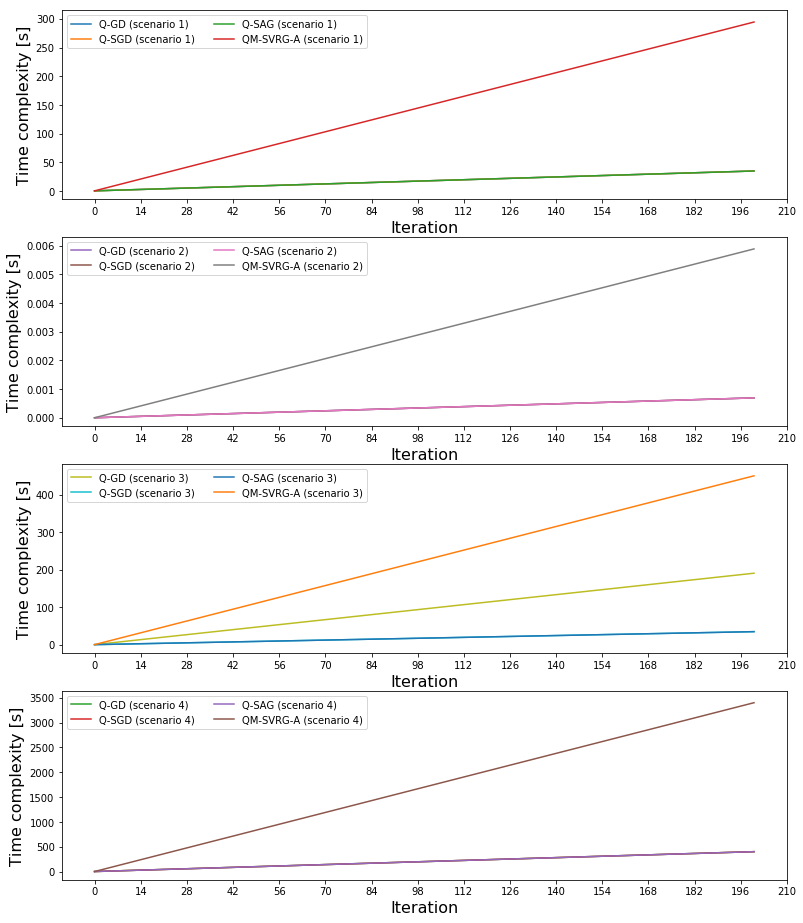

In [4]:
dimension = X_train.shape[1]
grad_quantization_opt = {'no_bits': 8, 'Range': 40}
parameter_quantization_opt = {'no_bits': 8, 'Range': 40}
communication_overhead = 64 + np.round(0.1*dimension)  # 8 bytes header plus 10% channel coding overhead   
rate_models = [{'p': 10e3, 'm': 10e3}, 
               {'p': 0.5e9, 'm': 0.5e9},
               {'p': 10e3, 'm': 1e3},
               {'p': dimension*grad_quantization_opt['no_bits'] + communication_overhead, 
                'm': dimension*grad_quantization_opt['no_bits'] + communication_overhead
               }
              ]    
             
hyper_parameters = {'lambda': 0.1, 'iterations': 200, 'SVRG_epoch_size': 8, 'dimension': dimension,
                    'parameter_quantization_opt': parameter_quantization_opt,
                    'grad_quantization_opt': grad_quantization_opt,
                    'grad_communication_overhead': communication_overhead,
                    'param_communication_overhead': communication_overhead,
                    'rate_model': rate_models}

#optimizers = ['GD', 'Q-GD', 'Q-SGD', 'Q-SAG', 'SVRG', 'M-SVRG', 'QM-SVRG-F', 'QM-SVRG-A'] 
optimizers = ['Q-GD', 'Q-SGD', 'Q-SAG', 'QM-SVRG-A'] 

latency = latency_evaluation(target_dataset, optimizers, hyper_parameters, no_class, plot=True) 
 
pickle_file_name = './TestResults/outputs_P_'+str(hyper_parameters['parameter_quantization_opt']['no_bits'])+'_Q_'+str(hyper_parameters['grad_quantization_opt']['no_bits'])+'_TimeComplexity_'+target_dataset
with open(pickle_file_name+'.pickle', 'wb') as f:
    pickle.dump(latency, f)

### Time complexity vs # bits 

$y$-axis shows the time it takes to converge to the optimal solution, measured by $\|\nabla F(\mathbf{w})\| \leq 0.1$. We test various scenarios for the transmission rate.

------ simulation with 8 bits is started (16 cases remains) ------
------ simulation with 9 bits is started (15 cases remains) ------
------ simulation with 10 bits is started (14 cases remains) ------
------ simulation with 11 bits is started (13 cases remains) ------
------ simulation with 12 bits is started (12 cases remains) ------
------ simulation with 13 bits is started (11 cases remains) ------
------ simulation with 14 bits is started (10 cases remains) ------
------ simulation with 15 bits is started (9 cases remains) ------
------ simulation with 16 bits is started (8 cases remains) ------
------ simulation with 17 bits is started (7 cases remains) ------
------ simulation with 18 bits is started (6 cases remains) ------
------ simulation with 19 bits is started (5 cases remains) ------
------ simulation with 20 bits is started (4 cases remains) ------
------ simulation with 21 bits is started (3 cases remains) ------
------ simulation with 22 bits is started (2 cases remain

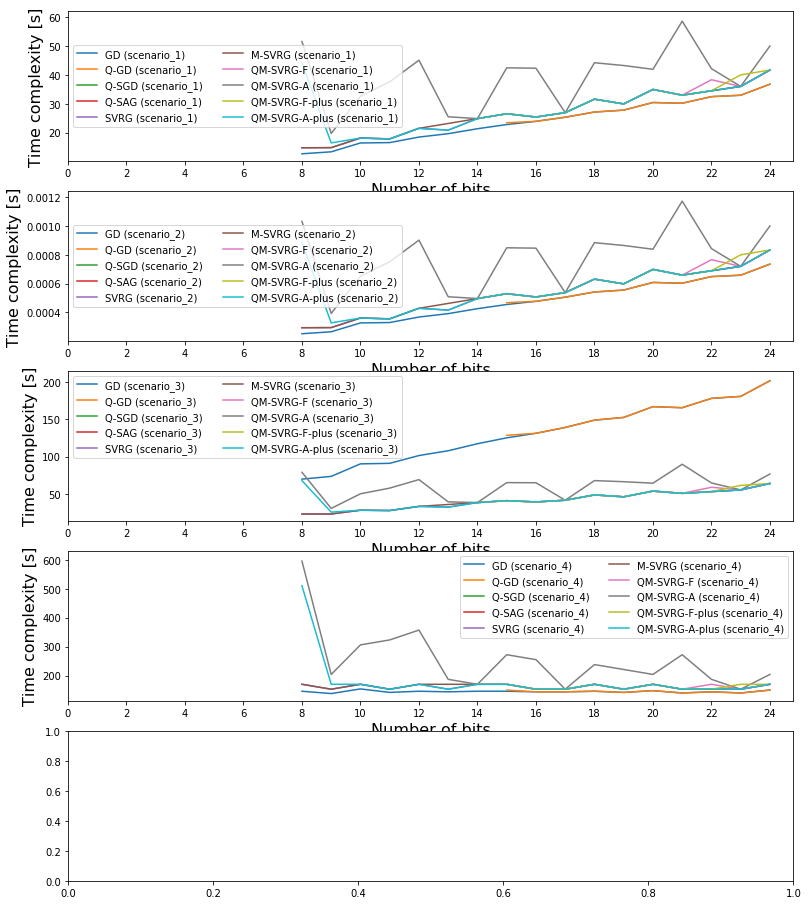

In [4]:
if no_class==2:
    # Initialize weights
    
    no_bits_sweep = range(8,25)
    outputs = {'no_bits_sweep': [no_bits for no_bits in no_bits_sweep], 
               'solution': [], 'time_complexity': [], 'convergence_time': []}

    for no_bits in no_bits_sweep:  
        print('------ simulation with {} bits is started ({} cases remains) ------'.format(no_bits, max(no_bits_sweep)-no_bits))
        # compute optimal solutions 
        dimension = X_train.shape[1]
        w_0 = initialize_w(dimension)
        grad_quantization_opt = {'no_bits': no_bits, 'Range': 40}
        parameter_quantization_opt = {'no_bits': no_bits, 'Range': 40}
        communication_overhead = 64 + np.round(0.1*dimension)  # 8 bytes header plus 10% channel coding overhead
        rate_models = [{'p': 10e3, 'm': 10e3}, 
                       {'p': 0.5e9, 'm': 0.5e9},
                       {'p': 10e3, 'm': 1e3},
                       {'p': dimension*grad_quantization_opt['no_bits'] + communication_overhead, 
                        'm': dimension*grad_quantization_opt['no_bits'] + communication_overhead
                       }
                      ]
                
        hyper_parameters = {'lambda': 0.1, 'iterations': 100, 'SVRG_epoch_size': 8, 'dimension': dimension, 'learning_rate': 0.2,
                            'parameter_quantization_opt': parameter_quantization_opt,
                            'grad_quantization_opt': grad_quantization_opt,
                            'grad_communication_overhead': communication_overhead,
                            'param_communication_overhead': communication_overhead,
                            'rate_model': rate_models}
        
        hyper_parameters['strong_convexity_param'] = 2 * hyper_parameters['lambda']
        Z = [X_train[i]*y_train[i] for i in range(X_train.shape[0])]
        hyper_parameters['smoothness_param'] = np.linalg.norm(Z)**2 / (4 * X_train.shape[0]) + 2 * hyper_parameters['lambda']
        #hyper_parameters['learning_rate'] = 1/(4*hyper_parameters['smoothness_param'])
        
        solution_new = optimizer_quantization_binary_classification(target_dataset, X_train, y_train, X_test, y_test,
                                                                    w_0, hyper_parameters, multi_class=False, 
                                                                    plot=False, printout=False)
        
        outputs['solution'].append(solution_new) 
        
        # compute latency      
        optimizers = ['GD', 'Q-GD', 'Q-SGD', 'Q-SAG', 
                      'SVRG', 'M-SVRG', 'QM-SVRG-F', 'QM-SVRG-A', 'QM-SVRG-F-plus', 'QM-SVRG-A-plus'] 
        
        latency_new = latency_evaluation(target_dataset, optimizers, hyper_parameters, no_class, plot=False) 
 
        outputs['time_complexity'].append(latency_new)
        
    outputs['convergence_time'] = time_complexy_vs_bits(outputs=outputs, grad_threshold=0.1, plot=True)

    pickle_file_name = './TestResults/outputs_TimevsBits'+target_dataset
    with open(pickle_file_name+'.pickle', 'wb') as f:
        pickle.dump(outputs, f)

else:
    print('Go to Section 3(b) for one-vs-all multiclass classification')

In [6]:
outputs['']

dict_keys(['no_bits_sweep', 'solution', 'time_complexity', 'convergence_time'])

In [12]:
outputs['time_complexity'][0]

{'scenario_1': {'GD': array([ 0.    ,  0.1732,  0.3464,  0.5196,  0.6928,  0.866 ,  1.0392,
          1.2124,  1.3856,  1.5588,  1.732 ,  1.9052,  2.0784,  2.2516,
          2.4248,  2.598 ,  2.7712,  2.9444,  3.1176,  3.2908,  3.464 ,
          3.6372,  3.8104,  3.9836,  4.1568,  4.33  ,  4.5032,  4.6764,
          4.8496,  5.0228,  5.196 ,  5.3692,  5.5424,  5.7156,  5.8888,
          6.062 ,  6.2352,  6.4084,  6.5816,  6.7548,  6.928 ,  7.1012,
          7.2744,  7.4476,  7.6208,  7.794 ,  7.9672,  8.1404,  8.3136,
          8.4868,  8.66  ,  8.8332,  9.0064,  9.1796,  9.3528,  9.526 ,
          9.6992,  9.8724, 10.0456, 10.2188, 10.392 , 10.5652, 10.7384,
         10.9116, 11.0848, 11.258 , 11.4312, 11.6044, 11.7776, 11.9508,
         12.124 , 12.2972, 12.4704, 12.6436, 12.8168, 12.99  , 13.1632,
         13.3364, 13.5096, 13.6828, 13.856 , 14.0292, 14.2024, 14.3756,
         14.5488, 14.722 , 14.8952, 15.0684, 15.2416, 15.4148, 15.588 ,
         15.7612, 15.9344, 16.1076, 16.2808,

# 3(b). Quantization with fixed and adaptive grids, multiclass classification 


.... Class 1 (out of 10) started ....
GD; Iter = 00; Objective(train) = 68.927; Objective(test) = 68.872; F1score(train) = 0.712; F1score(test) = 0.717
GD; Iter = 01; Objective(train) = 63.372; Objective(test) = 63.323; F1score(train) = 0.757; F1score(test) = 0.764
GD; Iter = 02; Objective(train) = 58.329; Objective(test) = 58.285; F1score(train) = 0.783; F1score(test) = 0.791
GD; Iter = 03; Objective(train) = 53.709; Objective(test) = 53.670; F1score(train) = 0.801; F1score(test) = 0.809
GD; Iter = 04; Objective(train) = 49.464; Objective(test) = 49.429; F1score(train) = 0.814; F1score(test) = 0.822
GD; Iter = 05; Objective(train) = 45.560; Objective(test) = 45.527; F1score(train) = 0.824; F1score(test) = 0.833
GD; Iter = 06; Objective(train) = 41.965; Objective(test) = 41.935; F1score(train) = 0.832; F1score(test) = 0.841
GD; Iter = 07; Objective(train) = 38.656; Objective(test) = 38.629; F1score(train) = 0.839; F1score(test) = 0.849
GD; Iter = 08; Objective(train) = 35.610; Objectiv

Q-SAG; Iter = 11; Objective(train) = 36.829; Objective(test) = 36.811; F1score(train) = 0.817; F1score(test) = 0.820
Q-SAG; Iter = 12; Objective(train) = 35.805; Objective(test) = 35.790; F1score(train) = 0.816; F1score(test) = 0.818
Q-SAG; Iter = 13; Objective(train) = 35.018; Objective(test) = 35.006; F1score(train) = 0.817; F1score(test) = 0.818
Q-SAG; Iter = 14; Objective(train) = 34.374; Objective(test) = 34.365; F1score(train) = 0.819; F1score(test) = 0.821
Q-SAG; Iter = 15; Objective(train) = 33.846; Objective(test) = 33.838; F1score(train) = 0.819; F1score(test) = 0.821
Q-SAG; Iter = 16; Objective(train) = 33.436; Objective(test) = 33.429; F1score(train) = 0.819; F1score(test) = 0.820
Q-SAG; Iter = 17; Objective(train) = 32.867; Objective(test) = 32.862; F1score(train) = 0.829; F1score(test) = 0.830
Q-SAG; Iter = 18; Objective(train) = 32.425; Objective(test) = 32.421; F1score(train) = 0.836; F1score(test) = 0.836
Q-SAG; Iter = 19; Objective(train) = 32.121; Objective(test) = 3

QM-SVRG-F; Iter = 18; Objective(train) = 26.176; Objective(test) = 26.169; F1score(train) = 0.899; F1score(test) = 0.901
QM-SVRG-F; Iter = 19; Objective(train) = 26.109; Objective(test) = 26.102; F1score(train) = 0.899; F1score(test) = 0.901
QM-SVRG-A; Iter = 00; Objective(train) = 44.603; Objective(test) = 44.564; F1score(train) = 0.795; F1score(test) = 0.805
QM-SVRG-A; Iter = 01; Objective(train) = 31.675; Objective(test) = 31.646; F1score(train) = 0.612; F1score(test) = 0.620
QM-SVRG-A; Iter = 02; Objective(train) = 31.675; Objective(test) = 31.646; F1score(train) = 0.612; F1score(test) = 0.620
QM-SVRG-A; Iter = 03; Objective(train) = 23.981; Objective(test) = 23.981; F1score(train) = 0.902; F1score(test) = 0.904
QM-SVRG-A; Iter = 04; Objective(train) = 16.628; Objective(test) = 16.619; F1score(train) = 0.925; F1score(test) = 0.925
QM-SVRG-A; Iter = 05; Objective(train) = 11.699; Objective(test) = 11.693; F1score(train) = 0.934; F1score(test) = 0.934
QM-SVRG-A; Iter = 06; Objective(

KeyboardInterrupt: 

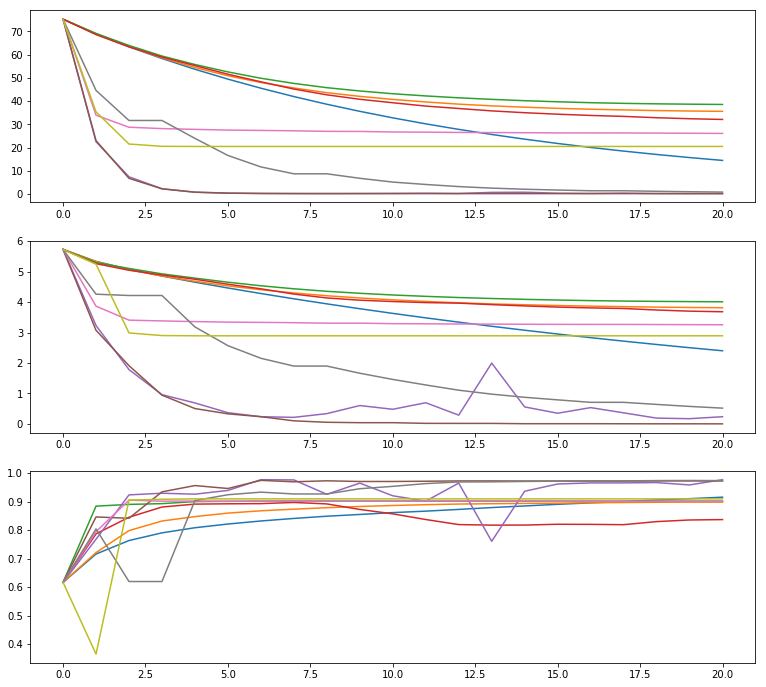

In [4]:
if no_class>2:
    grad_quantization_opt = {'no_bits': 10, 'Range': 40}
    parameter_quantization_opt = {'no_bits': 10, 'Range': 40}
    hyper_parameters = {'learning_rate': 0.2, 'lambda': 0.1, 'iterations': 20, 'SVRG_epoch_size': 15,
                        'parameter_quantization_opt': parameter_quantization_opt,
                        'grad_quantization_opt': grad_quantization_opt}

    w = list(np.arange(no_class))
    #for class_idx in noClass:
    for class_idx in np.arange(no_class):
        print('.... Class {} (out of {}) started ....'.format(class_idx+1,no_class))
        #y_train = np.copy(y_train_original)
        #y_test = np.copy(y_test_original)
        y_train[np.where(y_train_original==class_idx)] = 1
        y_train[np.where(y_train_original!=class_idx)] = -1
        y_test[np.where(y_test_original==class_idx)] = 1
        y_test[np.where(y_test_original!=class_idx)] = -1
        #print(y_train[0:20],'\n', y_test[0:20])
        #print(np.where(y_train==1)[0][0:10], np.where(y_test==1)[0][0:10])
        
        # Initialize weights
        w_0 = initialize_w(X_train.shape[1])
        hyper_parameters['strong_convexity_param'] = 2 * hyper_parameters['lambda']
        Z = [X_train[i]*y_train[i] for i in range(X_train.shape[0])]
        hyper_parameters['smoothness_param'] = np.linalg.norm(Z)**2 / (4*X_train.shape[0]) + 2*hyper_parameters['lambda']
        output_new = optimizer_quantization_multiclass_classification(target_dataset, X_train, y_train, X_test, y_test,
                                                                      w_0, hyper_parameters, 
                                                                      class_idx=class_idx)
        outputs[class_idx] = output_new
        print('.... Class {} (out of {}) ended, smoothness was {} ....'.format(class_idx+1,no_class, hyper_parameters['smoothness_param'] ))
        pickle_file_name = './TestResults/outputs_P_'+str(hyper_parameters['parameter_quantization_opt']['no_bits'])+'_Q_'+str(hyper_parameters['grad_quantization_opt']['no_bits'])+'_withQuant_'+target_dataset
        with open(pickle_file_name+'_solution.pickle', 'wb') as f:
            pickle.dump(outputs, f)


In [22]:
'''
#To load the results for existing solution of MNIST, run with noBits=str(7) or str(10) or any other existing value

noBits = str(10)
with open('./TestResults/P_'+noBits+'_Q_'+noBits+'_withQuant_MNIST_solution.pickle', 'rb') as f:
        w=pickle.load(f)
'''

y_pred = np.zeros(len(y_test_original), dtype=np.int64)
for idx in np.arange(len(y_test_original)):
    classProbabilities = [sigmoid(X_test[idx] @ w[i]['QM-SVRG-A']) for i in np.arange(10)]
    y_pred[idx] = int(classProbabilities.index(max(classProbabilities)))

print(f1_score(y_test_original, y_pred, average='micro'))

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_original, y_pred)

0.7168


array([[  59,    1,   98,   38,    3,  440,  244,   26,   67,    4],
       [   0, 1037,    3,    2,    1,   29,    3,    1,   59,    0],
       [   4,   46,  749,   18,   45,    3,   23,   32,  110,    2],
       [   9,    5,   56,  808,    3,   22,    7,   27,   69,    4],
       [   8,   12,    3,    3,  847,    0,   16,    4,   28,   61],
       [  25,   19,   24,  195,   32,  463,   35,   15,   74,   10],
       [   5,   15,   18,    1,   26,   24,  853,    3,   13,    0],
       [  61,   35,   14,    1,   12,    0,    3,  857,   33,   12],
       [   6,   24,   12,   47,    8,   20,   12,   15,  810,   20],
       [  17,   14,   11,   10,   83,   15,    7,   96,   71,  685]],
      dtype=int64)

In [ ]:
dimension = X_train.shape[1]
grad_quantization_opt = {'no_bits': 8, 'Range': 40}
parameter_quantization_opt = {'no_bits': 8, 'Range': 40}
grad_communication_overhead = 64 + np.round(0.1*dimension)  # 8 bytes header plus 10% channel coding overhead   
rate_model = [{'p': 10e3, 'm': 10e3}, 
              {'p': 10e6, 'm': 10e6},
              {'p': 10e3, 'm': 1e3},
              {'p': dimension*grad_quantization_opt['no_bits'] + communication_overhead, 
               'm': dimension*grad_quantization_opt['no_bits'] + communication_overhead
              }
             ]    
             
hyper_parameters = {'lambda': 0.1, 'iterations': 30, 'SVRG_epoch_size': 8,
                    'parameter_quantization_opt': parameter_quantization_opt,
                    'grad_quantization_opt': grad_quantization_opt,
                    'grad_communication_overhead': communication_overhead,
                    'param_communication_overhead': communication_overhead,
                    'rate_model': rate_model}

optimizers = ['GD', 'Q-GD', 'Q-SGD', 'Q-SAG', 'SVRG', 'M-SVRG', 'QM-SVRG-F', 'QM-SVRG-A'] 

latency = latency_evaluation(target_dataset, optimizers, hyper_parameters, no_class)
    
pickle_file_name = './TestResults/P_'+str(hyper_parameters['parameter_quantization_opt']['no_bits'])+'_Q_'+str(hyper_parameters['grad_quantization_opt']['no_bits'])+'_TimeComplexity_'+target_dataset
with open(pickle_file_name+'_solution.pickle', 'wb') as f:
    pickle.dump(latency, f)

# Theoretical bounds 

Now, lets depict some of our bounds on the feasible choices of $\alpha_k$, $T$, and the minimum number of bits per coordinate $b/d$ as a function of dimension $d$. 

### Convergence of QM-SVRG-F (quantized SVRG with fixed quantization grids)
In Proposition 1 (convergence of SVRG with fixed grid), we have that $\alpha_k < \dfrac{1}{4L}$ and $T > \dfrac{1}{\mu \alpha_k (1-4L \alpha_k)}$. Moreover, to ensure a contraction factor $\sigma_0 (0 \leq \sigma_0 <1)$, we should have 
$$0 \leq \alpha_k < \dfrac{\sigma_0}{2L(1+\sigma_0)} \quad \text{and}  \quad T > \dfrac{1}{\mu \alpha_k (\sigma_0-2L \alpha_k \sigma_0 - 2L \alpha_k)} \:.$$

### Convergence of QM-SVRG-A (quantized SVRG with adaptive quantization grids)
In Proposition 3 (convergence of SVRG with adaptive grid), we have that 
$$0 \leq \alpha_k < \dfrac{1}{4L} \quad \text{and} \quad \alpha_k (1-4L\alpha_k) > \frac{4L\left(1+4\mu^2 \alpha_k^2\right)}{\mu^2} \frac{d}{\left(2^{b/d}-1\right)^2}$$
and $$T > \dfrac{1}{\mu \alpha_k (1-4L \alpha_k) - {2L\left(1+2\mu \alpha_k^2\right)} \dfrac{\sqrt{d}}{2^{b/d}-1} }\:.$$
Moreover, to ensure a contraction factor of at least $\sigma_0 \in [0,1)$, we should have 
$$\alpha_k < \dfrac{\sigma_0}{2L(1+\sigma_0)} 
~~ ,  ~~
\alpha_k (\sigma_0-2L \alpha_k \sigma_0 - 2L \alpha_k) > \frac{4L\left(1+4\mu^2 \alpha_k^2\right)}{\mu^2} \frac{d}{\left(2^{b/d}-1\right)^2}
$$ 
and 
$$
T > \dfrac{1}{\mu \alpha_k (\sigma_0-2L \alpha_k \sigma_0 - 2L \alpha_k)- {\dfrac{4L}{\mu}\left(1+4\mu^2 \alpha_k^2\right)} \dfrac{d}{\left(2^{b/d}-1\right)^2} }
\:.$$
The second condition on $\alpha_k$ implies that the minimum number of bits to ensure positivity of $T$ follows 
$$
\frac{b}{d} \geq \left\lceil \log_2 \left( 1 + \sqrt{\dfrac{4Ld\left(1+4\mu^2 \alpha_k^2\right)}{\mu^2 \alpha_k (\sigma_0-2L \alpha_k \sigma_0 - 2L \alpha_k)}}\right) \right\rceil .$$ 


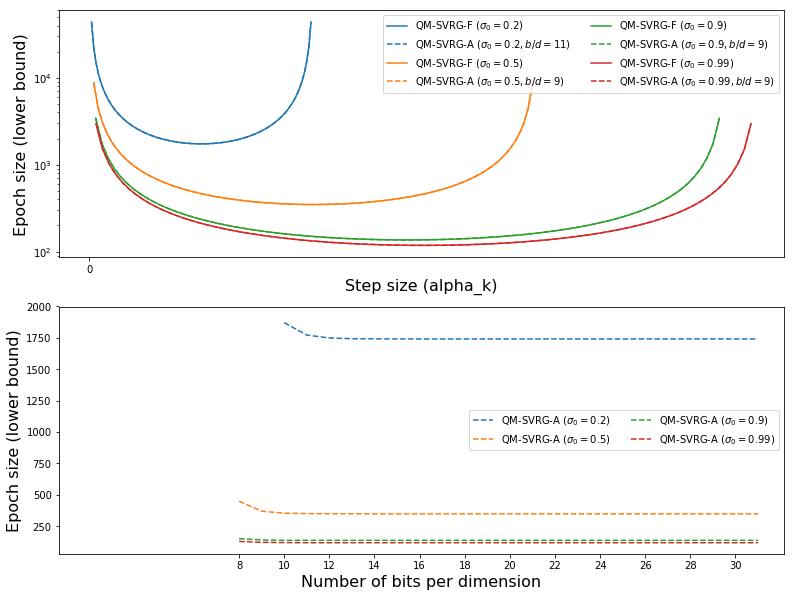

In [2]:
dimension = X_train.shape[1]
hyper_parameters = {'learning_rate': 0.12, 'lambda': 0.1}
    
Z = [X_train[i]*y_train[i] for i in range(X_train.shape[0])]
hyper_parameters['strong_convexity_param'] = 2 * hyper_parameters['learning_rate']
hyper_parameters['smoothness_param'] = np.linalg.norm(Z)**2 / (4 * X_train.shape[0]) + 2 * hyper_parameters['learning_rate']


sigma = [0.2, 0.5, 0.9, 0.99]

fig, ax = plt.subplots(2, 1, figsize=(13, 10))
for sigma_0 in sigma: 
    alpha_UL = alpha_UB_FixedGrid(L=hyper_parameters['smoothness_param'], sigma_0 = sigma_0)
    alpha_set = np.linspace(start = 0.01*alpha_UL, stop = 0.99*alpha_UL, num = 100)
    T_LB_FGrid, no_bits_perdimension_LB, T_LB_AGrid = np.zeros(len(alpha_set)), np.zeros(len(alpha_set)), np.zeros(len(alpha_set))
    i = 0

    for alpha in alpha_set:
        T_LB_FGrid[i] = T_LB_FixedGrid(mu = hyper_parameters['strong_convexity_param'],alpha=alpha,sigma_0 = sigma_0,
                                       L=hyper_parameters['smoothness_param'])
        
        no_bits_perdimension_LB[i] = noBitsPerDimension_LB(d=dimension, L=hyper_parameters['smoothness_param'],
                                                           mu=hyper_parameters['strong_convexity_param'],
                                                           alpha=alpha,sigma_0 = sigma_0)
        
        T_LB_AGrid[i] = T_LB_AdaptiveGrid(mu=hyper_parameters['strong_convexity_param'],alpha=alpha,sigma_0 = sigma_0,
                                          L=hyper_parameters['smoothness_param'],
                                          b=(no_bits_perdimension_LB[i]+20)*dimension, d=dimension) 
        i += 1

    color = next(ax[0]._get_lines.prop_cycler)['color']
    ax[0].semilogy(alpha_set, T_LB_FGrid, label="QM-SVRG-F ($\sigma_0 = {}$)".format(sigma_0), linestyle="-", color=color)
    ax[0].semilogy(alpha_set, T_LB_AGrid, label="QM-SVRG-A ($\sigma_0 = {}, b/d = {}$)".format(sigma_0, int(np.ceil(np.mean(no_bits_perdimension_LB)))),
               linestyle="--", color=color)        
    alpha_k = alpha_UL/2  
    no_bits_perdimension_LB_new_alpha = noBitsPerDimension_LB(d=dimension, L=hyper_parameters['smoothness_param'],
                                                 mu=hyper_parameters['strong_convexity_param'],
                                                 alpha=alpha_k,sigma_0 = sigma_0)
    no_bits_perdimension_set = np.arange(no_bits_perdimension_LB_new_alpha, max(32,no_bits_perdimension_LB_new_alpha))
        
    T_LB_AGrid = [np.ceil(T_LB_AdaptiveGrid(mu = hyper_parameters['strong_convexity_param'],alpha=alpha_k,sigma_0 = sigma_0,
                                            L=hyper_parameters['smoothness_param'],
                                            b=dimension*no_bits, d=dimension)) for no_bits in no_bits_perdimension_set]

    ax[1].plot(no_bits_perdimension_set, T_LB_AGrid, label="QM-SVRG-A ($\sigma_0 = {}$)".format(sigma_0), 
               linestyle="--", color=color)
    

    #print('sigma_0 = {}, alpha_UL = {:.4f}, noB_LB = {}, noB_LB_alpha/2 = {}, T_LB = {}'.format(sigma_0, alpha_UL,no_bits_perdimension_LB,no_bits_perdimension_LB_new_alpha, T_LB_AGrid[-1]))
        
ax_modifier(ax=ax[0], legend_loc="upper right", ncol=2, xlabel="Step size (alpha_k)", 
            ylabel="Epoch size (lower bound)")

ax_modifier(ax=ax[1], legend_loc="upper right", ncol=2, xlabel="Number of bits per dimension", 
            ylabel="Epoch size (lower bound)")
   
ax[1].set_xticks(np.arange(no_bits_perdimension_set[0], no_bits_perdimension_set[-1], step=2))

fig_name = './TestResults/Epoch_size_LB_'+target_dataset
plt.savefig(fig_name+'.png')
plt.savefig(fig_name+'.eps', format='eps', bbox_inches = 'tight')
matplotlib2tikz.save(fig_name+'.tex')


# Aditional materials 

In [ ]:
"""
no_bits = 5
Range_gradients = 5
w = w_0
hyper_parameters['SVRG_epoch_size'] = 5
sampler = random_sampler(X_train.shape[0], hyper_parameters['SVRG_epoch_size'])  

no_samples, dimension = X_train.shape
local_datasets = np.array([i*np.floor(no_samples/(no_nodes))   for i in range(no_nodes)], dtype=np.int64)
local_datasets = np.append(local_datasets, [no_samples])

epoch_no = 1
for batch in sampler:
    full_grad = gradient_full(X_train, y_train, w, hyper_parameters['lambda'])
    sum_quantized_grad = np.zeros(dimension, dtype=np.float64)
    for i in range(no_nodes):
        full_grad_node = full_grad[local_datasets[i]:local_datasets[i+1]]
        mean_grad_node = np.mean(full_grad_node, axis=0)
        
        # Quantization step 
        if isinstance(no_bits, int): 
            no_bits_vect = np.tile([no_bits], dimension)
            grid_center = np.tile([0], dimension)
            quantization_radius = np.tile([Range_gradients], dimension)
            quantized_mean_grad_node = vector_quantization(original_vector = mean_grad_node, quantization_radius = quantization_radius, 
                                                   grid_center = grid_center, no_bits = no_bits_vect)    
            
        sum_quantized_grad = np.add(sum_quantized_grad, quantized_mean_grad_node)
    mean_quantized_grad = sum_quantized_grad/no_nodes 
    
    iteration_no = 0
    for ix in batch:
        grad = gradient_single(X_train[ix], y_train[ix], w, hyper_parameters['lambda'])
        quantized_grad = vector_quantization(original_vector = grad, quantization_radius = quantization_radius, 
                                                   grid_center = grid_center, no_bits = no_bits_vect) 
        quantized_full_grad_ix = vector_quantization(original_vector = full_grad[ix], quantization_radius = quantization_radius, 
                                                   grid_center = grid_center, no_bits = no_bits_vect) 
        w = w - hyper_parameters['learning_rate'] * (quantized_grad - quantized_full_grad_ix + mean_quantized_grad)
        iteration_no += 1
        print('Epoch  {},  Iteration  {}, new param:  {}'.format(epoch_no, iteration_no, w))
    epoch_no += 1
"""

# (TEMP): No quantization, binary classification 

In [ ]:
# Initialize weights
w_0 = initialize_w(X_train.shape[1])

hyper_parameters = {'learning_rate': 0.2, 'lambda': 0.1, 'iterations': 20, 
                    'SVRG_epoch_size': 5}

optimizers = [
    {
        "opt": SGD(X=X_train, y=y_train, w=w_0, lmbda=hyper_parameters['lambda'], 
                   learning_rate=hyper_parameters['learning_rate'], batch_size=1),
        "name": "SGD",
        "inner": 1
    },
    {
        "opt": SAG(X=X_train, y=y_train, w=w_0, lmbda=hyper_parameters['lambda'], 
                   learning_rate=hyper_parameters['learning_rate']),
        "name": "SAG",
        "inner": 1
    },
    {
        "opt": SVRG(X=X_train, y=y_train, w=w_0, lmbda=hyper_parameters['lambda'], 
                    learning_rate=hyper_parameters['learning_rate'], 
                    epoch_size=hyper_parameters['SVRG_epoch_size']),
        "name": "SVRG",
        "inner": 1
    },
    {
        "opt": SVRG_modified(X=X_train, y=y_train, w=w_0, lmbda=hyper_parameters['lambda'], 
                             learning_rate=hyper_parameters['learning_rate'], 
                             epoch_size=hyper_parameters['SVRG_epoch_size']),
        "name": "M-SVRG",
        "inner": 1
    },
    {
        "opt": gradient_descent(X=X_train, y=y_train, w=w_0, lmbda=hyper_parameters['lambda'],
                                learning_rate=hyper_parameters['learning_rate'],
                                iterations = hyper_parameters['iterations']),
        "name": "GD",
        "inner": 1
    },
]


fig, ax = plt.subplots(3, 1, figsize=(13, 10))

for opt in optimizers:
    # training_loss and testing_loss includes references to the training
    # and test set respectively.

    loss_hist_train, loss_hist_test, train_f1_score, test_f1_score, clock, mean_grad_norm = iterate(
        opt['opt'],
        w_0,
        training_loss, testing_loss, hyper_parameters['iterations'], inner=opt['inner'],
        name=opt['name'])
    color = next(ax[0]._get_lines.prop_cycler)['color']

    iterations_axis = range(0, hyper_parameters['iterations'] + 1)
    ax[0].plot(iterations_axis, loss_hist_train,
               label="Train loss ({})".format(opt['name']), linestyle="-", color=color)

    ax[0].plot(iterations_axis, loss_hist_test,
               label="Test loss ({})".format(opt['name']), linestyle="--", color=color)

    ax[1].plot(iterations_axis, mean_grad_norm,
               label="Training ({})".format(opt['name']), linestyle="-", color=color)
    
    ax[2].plot(iterations_axis, train_f1_score,
               label="Train F1 score ({})".format(opt['name']), linestyle="-", color=color)

    ax[2].plot(iterations_axis, test_f1_score,
               label="Test F1 score ({})".format(opt['name']), linestyle="--", color=color)

    #ax[3].plot(clock, loss_hist_train,
    #           label="Train loss ({})".format(opt['name']), linestyle="-", color=color)

    #ax[3].plot(clock, loss_hist_test,
    #           label="Test loss ({})".format(opt['name']), linestyle="--", color=color)
    
    ax_modifier(ax=ax[0], legend_loc="upper right", xlabel="Iteration", ylabel="Loss", 
                title="Performance Comparison of various algorithms")
    
    ax_modifier(ax=ax[1], legend_loc="upper right", xlabel="Iteration", ylabel="Gradient norm (training data)")

    ax_modifier(ax=ax[2], legend_loc="lower right", xlabel="Iteration", ylabel="F1 score")
    
    #ax_modifier(ax=ax[3], legend_loc="upper right", xlabel="Time in seconds", ylabel="Loss")

ax[0].set_xticks(np.arange(0, 21, step=2))
ax[1].set_xticks(np.arange(0, 21, step=2))
ax[0].legend(ncol=2)
ax[1].legend(ncol=2)
#ax[2].legend(ncol=2)
plt.savefig('./TestResults/FullPrecision_PerformanceComparison_'+target_dataset+'.png')
plt.savefig('./TestResults/FullPrecision_PerformanceComparison_'+target_dataset+'.eps', format='eps', bbox_inches = 'tight')

# (TEMP): Quantization with fixed and adaptive grids, binary classification 


In [ ]:
# Initialize weights
w_0 = initialize_w(X_train.shape[1])
#w_0 = np.array([ 0.064, -0.189,  0.711,  0.108,  0.093,  0.772], dtype=np.float32)
no_nodes = 10

grad_quantization_opt = {'no_bits': 3, 'Range': 40}
parameter_quantization_opt = {'no_bits': 3, 'Range': 40}

hyper_parameters = {'learning_rate': 0.12, 'lambda': 0.1, 'iterations': 15, 'SVRG_epoch_size': 5,
                    'parameter_quantization_opt': parameter_quantization_opt,
                    'grad_quantization_opt': grad_quantization_opt}

hyper_parameters['strong_convexity_param'] = 2 * hyper_parameters['learning_rate']
Z = [X_train[i]*y_train[i] for i in range(X_train.shape[0])]
hyper_parameters['smoothness_param'] = np.linalg.norm(Z)**2 / (4 * X_train.shape[0]) + 2 * hyper_parameters['learning_rate']


optimizers = [
    {
        "opt": SVRG(X=X_train, y=y_train, w=w_0, lmbda=hyper_parameters['lambda'], 
                    learning_rate=hyper_parameters['learning_rate'], 
                    epoch_size=hyper_parameters['SVRG_epoch_size']),
        "name": "SVRG",
        "inner": 1
    },
    {
        "opt": SVRG_modified(X=X_train, y=y_train, w=w_0, lmbda=hyper_parameters['lambda'], 
                             learning_rate=hyper_parameters['learning_rate'], 
                             epoch_size=hyper_parameters['SVRG_epoch_size']),
        "name": "M-SVRG",
        "inner": 1
    },
    {
        "opt": SVRG_fixed_quantization(X=X_train, y=y_train, w=w_0, lmbda=hyper_parameters['lambda'],
                                       learning_rate=hyper_parameters['learning_rate'], 
                                       epoch_size=hyper_parameters['SVRG_epoch_size'],
                                       parameter_quantization_opt=hyper_parameters['parameter_quantization_opt'], 
                                       grad_quantization_opt=hyper_parameters['grad_quantization_opt']),
        "name": "QM-SVRG-F",
        "inner": 1
    },
    {
        "opt": SVRG_adaptive_quantization(X=X_train, y=y_train, w=w_0, lmbda=hyper_parameters['lambda'],
                                       learning_rate=hyper_parameters['learning_rate'], 
                                       epoch_size=hyper_parameters['SVRG_epoch_size'],
                                       parameter_quantization_opt=hyper_parameters['parameter_quantization_opt'], 
                                       grad_quantization_opt=hyper_parameters['grad_quantization_opt'],
                                       strong_convexity_param=hyper_parameters['strong_convexity_param']),
        "name": "QM-SVRG-A",
        "inner": 1
    },    
]

fig, ax = plt.subplots(3, 1, figsize=(13, 15))

for opt in optimizers:
    # training_loss and testing_loss includes references to the training
    # and test set respectively.

    loss_hist_train, loss_hist_test, train_f1_score, test_f1_score, clock, mean_grad_norm = iterate(
        opt['opt'],
        w_0,
        training_loss, testing_loss, hyper_parameters['iterations'], inner=opt['inner'],
        name=opt['name'])
    color = next(ax[0]._get_lines.prop_cycler)['color']

    iterations_axis = range(0, hyper_parameters['iterations'] + 1)
    ax[0].plot(iterations_axis, loss_hist_train,
               label="Train loss ({})".format(opt['name']), linestyle="-", color=color)

    ax[0].plot(iterations_axis, loss_hist_test,
               label="Test loss ({})".format(opt['name']), linestyle="--", color=color)
    
    ax[1].plot(iterations_axis, mean_grad_norm,
               label="{}".format(opt['name']), linestyle="-", color=color)    
    
    ax[2].plot(iterations_axis, train_f1_score,
               label="Train F1 score ({})".format(opt['name']), linestyle="-", color=color)

    ax[2].plot(iterations_axis, test_f1_score,
               label="Test F1 score ({})".format(opt['name']), linestyle="--", color=color)

    #ax[3].plot(clock, loss_hist_train,
    #           label="Train loss ({})".format(opt['name']), linestyle="-", color=color)

    #ax[3].plot(clock, loss_hist_test,
    #           label="Test loss ({})".format(opt['name']), linestyle="--", color=color)
    
    ax_modifier(ax=ax[0], legend_loc="center right", xlabel="Iteration", ylabel="Loss")
    
    ax_modifier(ax=ax[1], legend_loc="center right", xlabel="Iteration", ylabel="Gradient norm (training data)")

    ax_modifier(ax=ax[2], legend_loc="center right", xlabel="Iteration", ylabel="F1 score")

    #ax_modifier(ax=ax[3], legend_loc="upper right", xlabel="Time in seconds", ylabel="Loss")

ax[0].set_xticks(np.arange(0, 16, step=3))
ax[1].set_xticks(np.arange(0, 16, step=3))
ax[0].legend(ncol=2)
ax[1].legend(ncol=2)
fig_name = './TestResults/P_'+str(parameter_quantization_opt['no_bits'])+'_Q_'+str(grad_quantization_opt['no_bits'])
plt.savefig(fig_name+'_QuantizationAdaptiveGrid_'+target_dataset+'.png')
plt.savefig(fig_name+'_QuantizationAdaptiveGrid_'+target_dataset+'.eps', format='eps', bbox_inches = 'tight')
